In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from plot_transients_function import *
import seaborn as sns

# set seaborn style 'text', usetex=True
rc={'axes.labelsize': 20, 'font.size': 20, 'legend.fontsize': 20, 'axes.titlesize': 20,
    'xtick.labelsize' : 20, 'ytick.labelsize' : 20, 'font.family' : 'serif',
    'axes.grid' : True, 'grid.color' : 'k', 'grid.linestyle' : '--'}
sns.set(style="whitegrid", rc=rc)
plt.rcParams.update(**rc)
#plt.grid(color='k', linestyle='--', linewidth=0.5)

In [2]:
# Prepare files
def load_pkl(path):
    filenames = glob.glob(path)

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_pickle(filename))
    concat_df = pd.concat(dfs, ignore_index=True)
    return concat_df

def convert_to_datetime(timestamp_as_str):
    """Convert a timestring as str to pandas timestring dtype

    Args:
        timestamp_as_str: Timestamp in string format

    Returns:
        A readable timestamp for pandas
    """
    date, time, time_ns = timestamp_as_str.split('_')
    return pd.to_datetime(date + ' ' + time + '.' + time_ns, dayfirst=True)

# import data
data = load_pkl('../transient_features/*')
data['begin_timestamp'] = data['begin_timestamp_string'].apply(convert_to_datetime)

# search max value
data[['peak1','peak2','peak3']] = pd.DataFrame(data['three_first_peaks'].values.tolist(), index= data.index)
data[['peak1','peak2','peak3']] = data[['peak1','peak2','peak3']].astype(np.float64)
data['max'] = data[['peak1','peak2','peak3']].max(axis=1)

# Allgemeine Verteilung der Transienten über die Tageszeit

In [84]:
# Load charging data
df_charging = pd.concat(map(pd.read_pickle, glob.glob(os.path.join('', "../Event_dfs/*.pkl"))))
df_charging = df_charging[~df_charging['timestamp'].duplicated()]
df_charging_times = pd.to_datetime(df_charging.timestamp, unit='s').dt.hour

In [85]:
df_charging_times = df_charging_times + 2

In [86]:
data['stunden'] = data['begin_timestamp_string'].apply(lambda x: x[11:13]).astype(int)
data['stunden_minuten'] = data['begin_timestamp_string'].apply(lambda x: x[11:16])
data['stunden_minuten'] = data['stunden_minuten'].str.replace(':', '.').astype(np.float64)

In [87]:
data['stunden'].max()

23

<IPython.core.display.Javascript object>


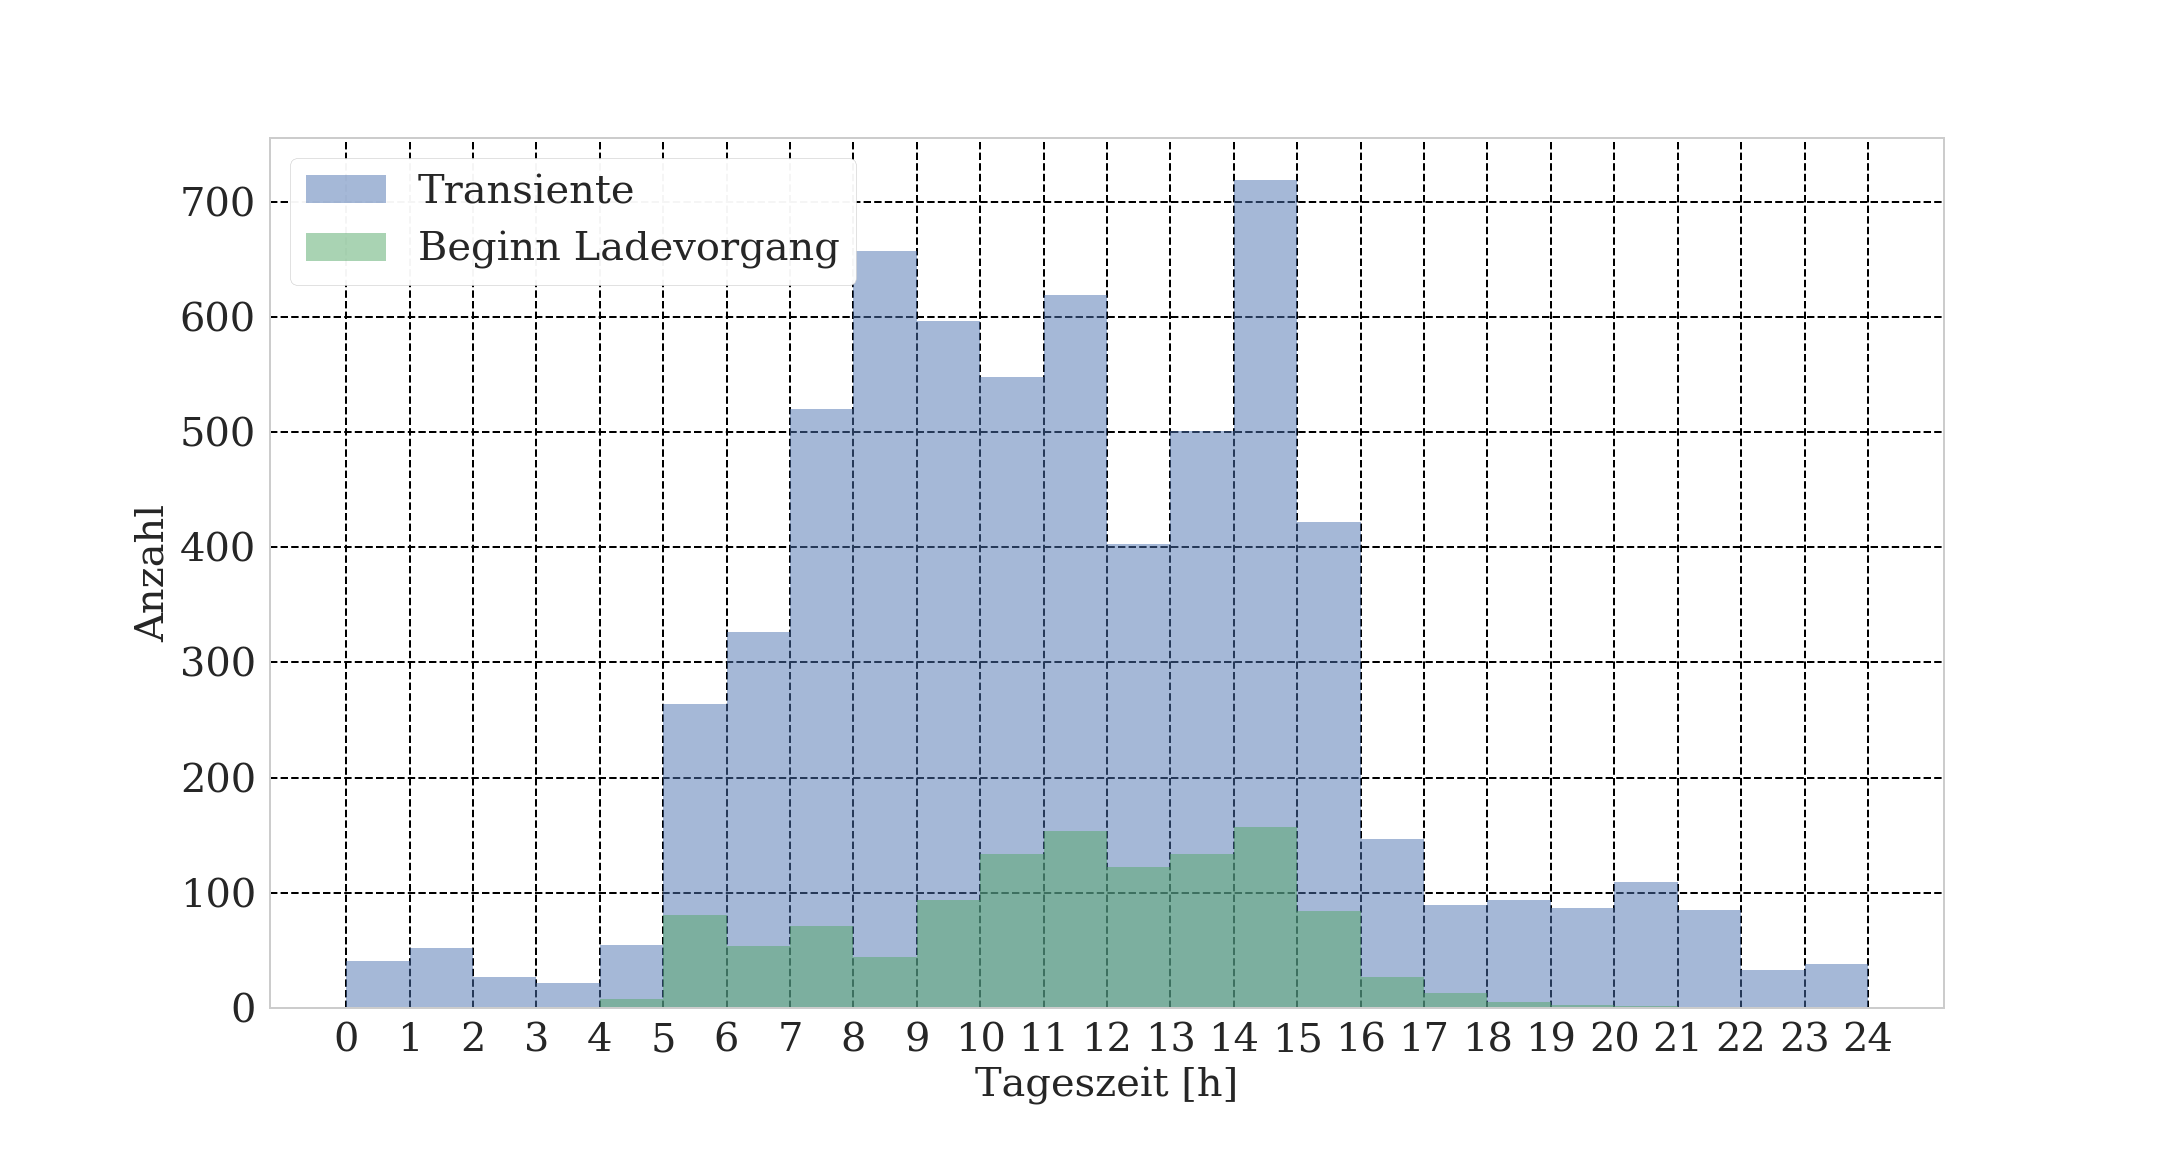

In [88]:
plt.figure(figsize=(15,8))
n, bins, patches = plt.hist(data['stunden'], bins=24, range=[0, 24], alpha=0.5, label=r'Transiente')
n, bins, patches = plt.hist(df_charging_times, bins=bins, alpha=0.5, label=r'Beginn Ladevorgang')
plt.xticks(np.arange(0, 25, 1))
xlabel(r'Tageszeit [h]')
ylabel(r"Anzahl")
plt.legend(loc='upper left', frameon = True, framealpha=10)
plt.show()
savefig('test.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


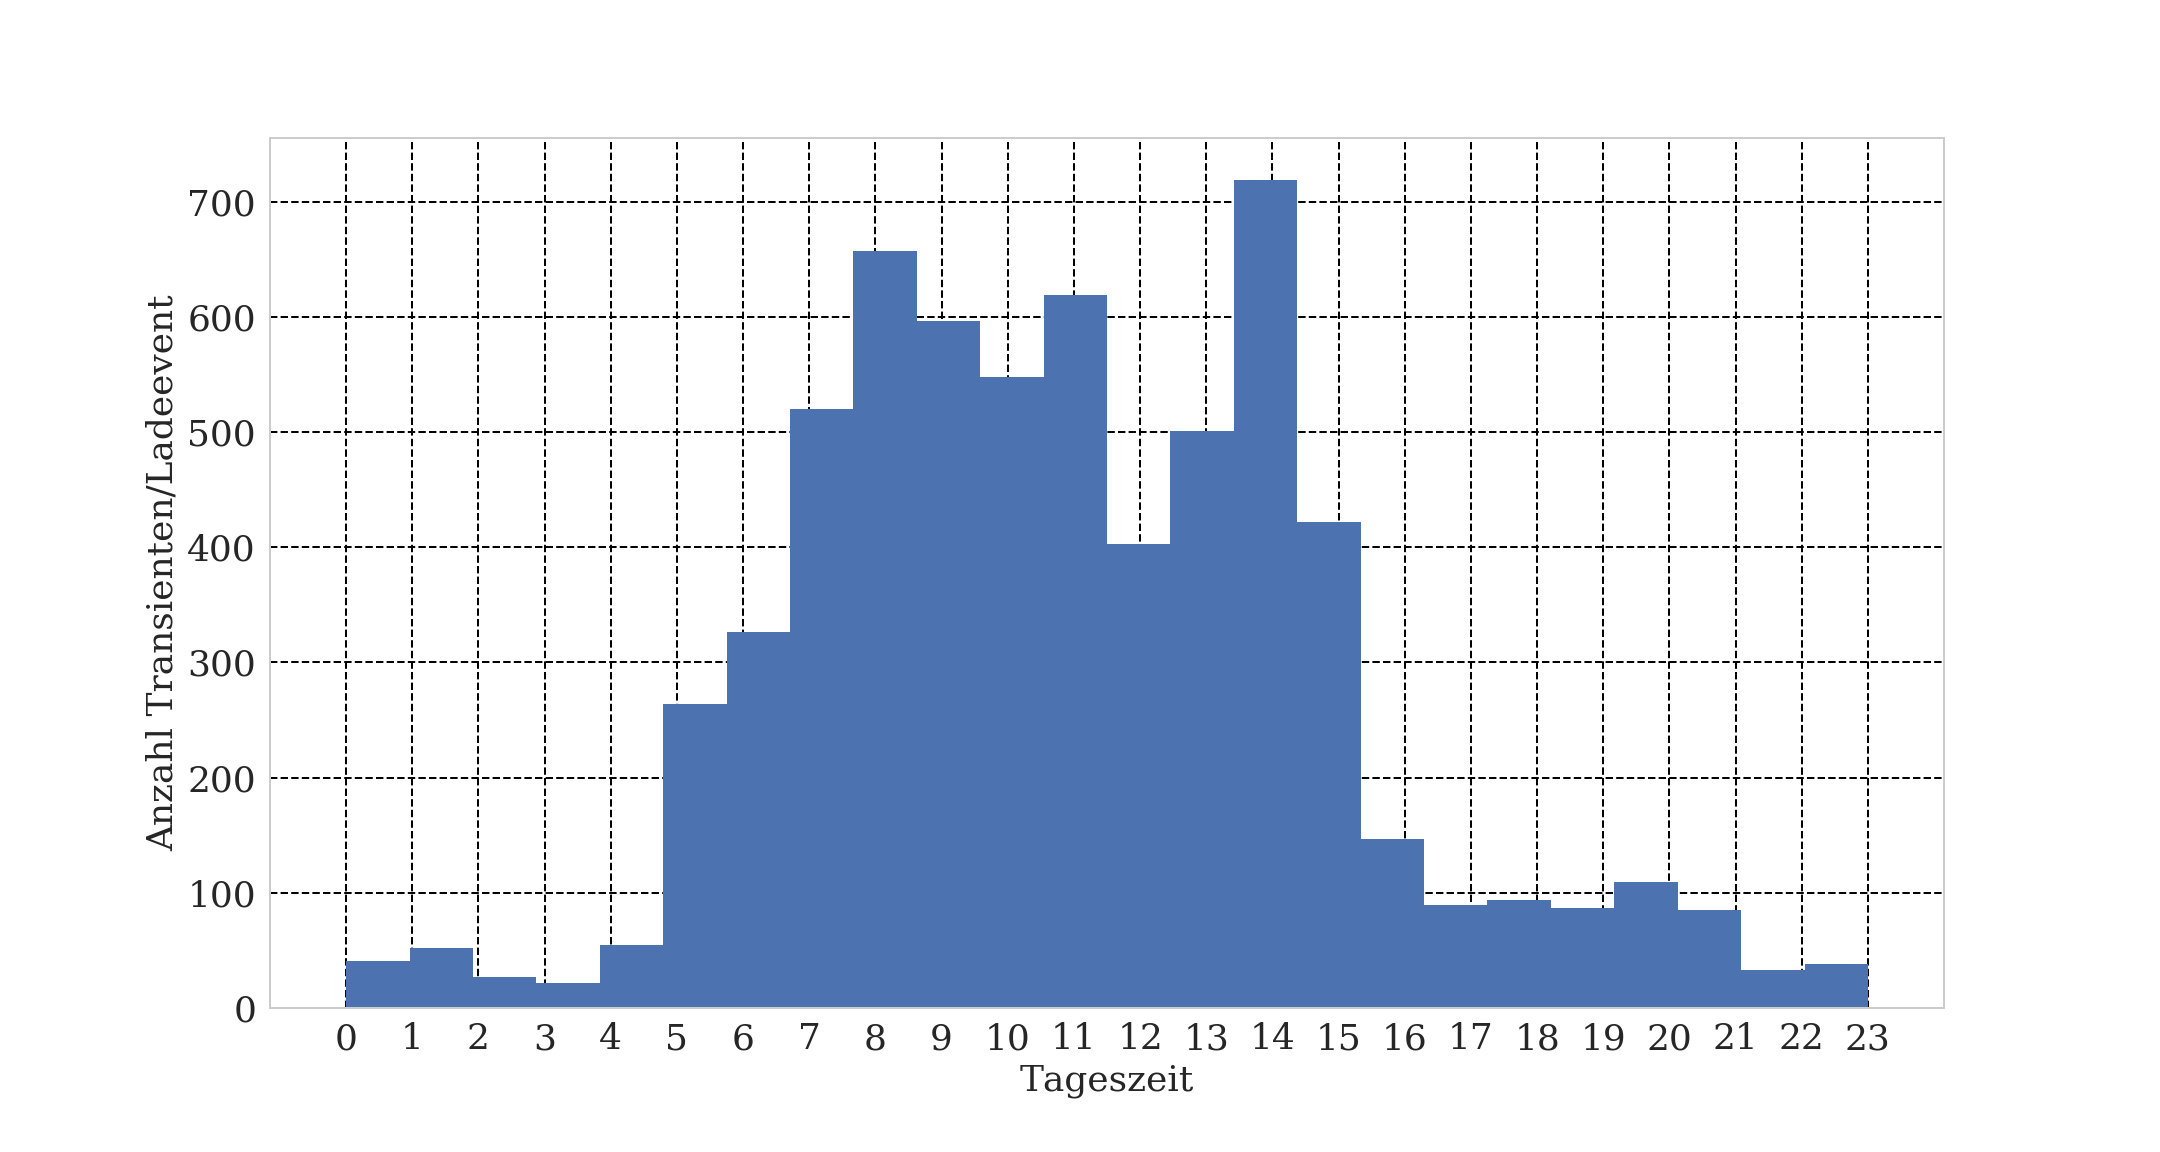

In [42]:
# Initialize the matplotlib figure
plt.figure()
xlabel(r'Tageszeit')
plot = data['stunden'].plot.hist(bins=24, figsize=(15,8), grid=True)
plot.set_ylabel(r"Anzahl Transienten")
plot.set_xticks(np.arange(0, 24, 1))
savefig('zeit_haeufung.pdf', format='pdf', dpi=1200)

# Untersuchung von Plugin on this phase

In [77]:
plugin_on_this_phase = data[data['plugin_on_this_phase']]

# prepare data
plot = plugin_on_this_phase.copy()
plot_dia = plot[plot['max'] < 200]

<IPython.core.display.Javascript object>


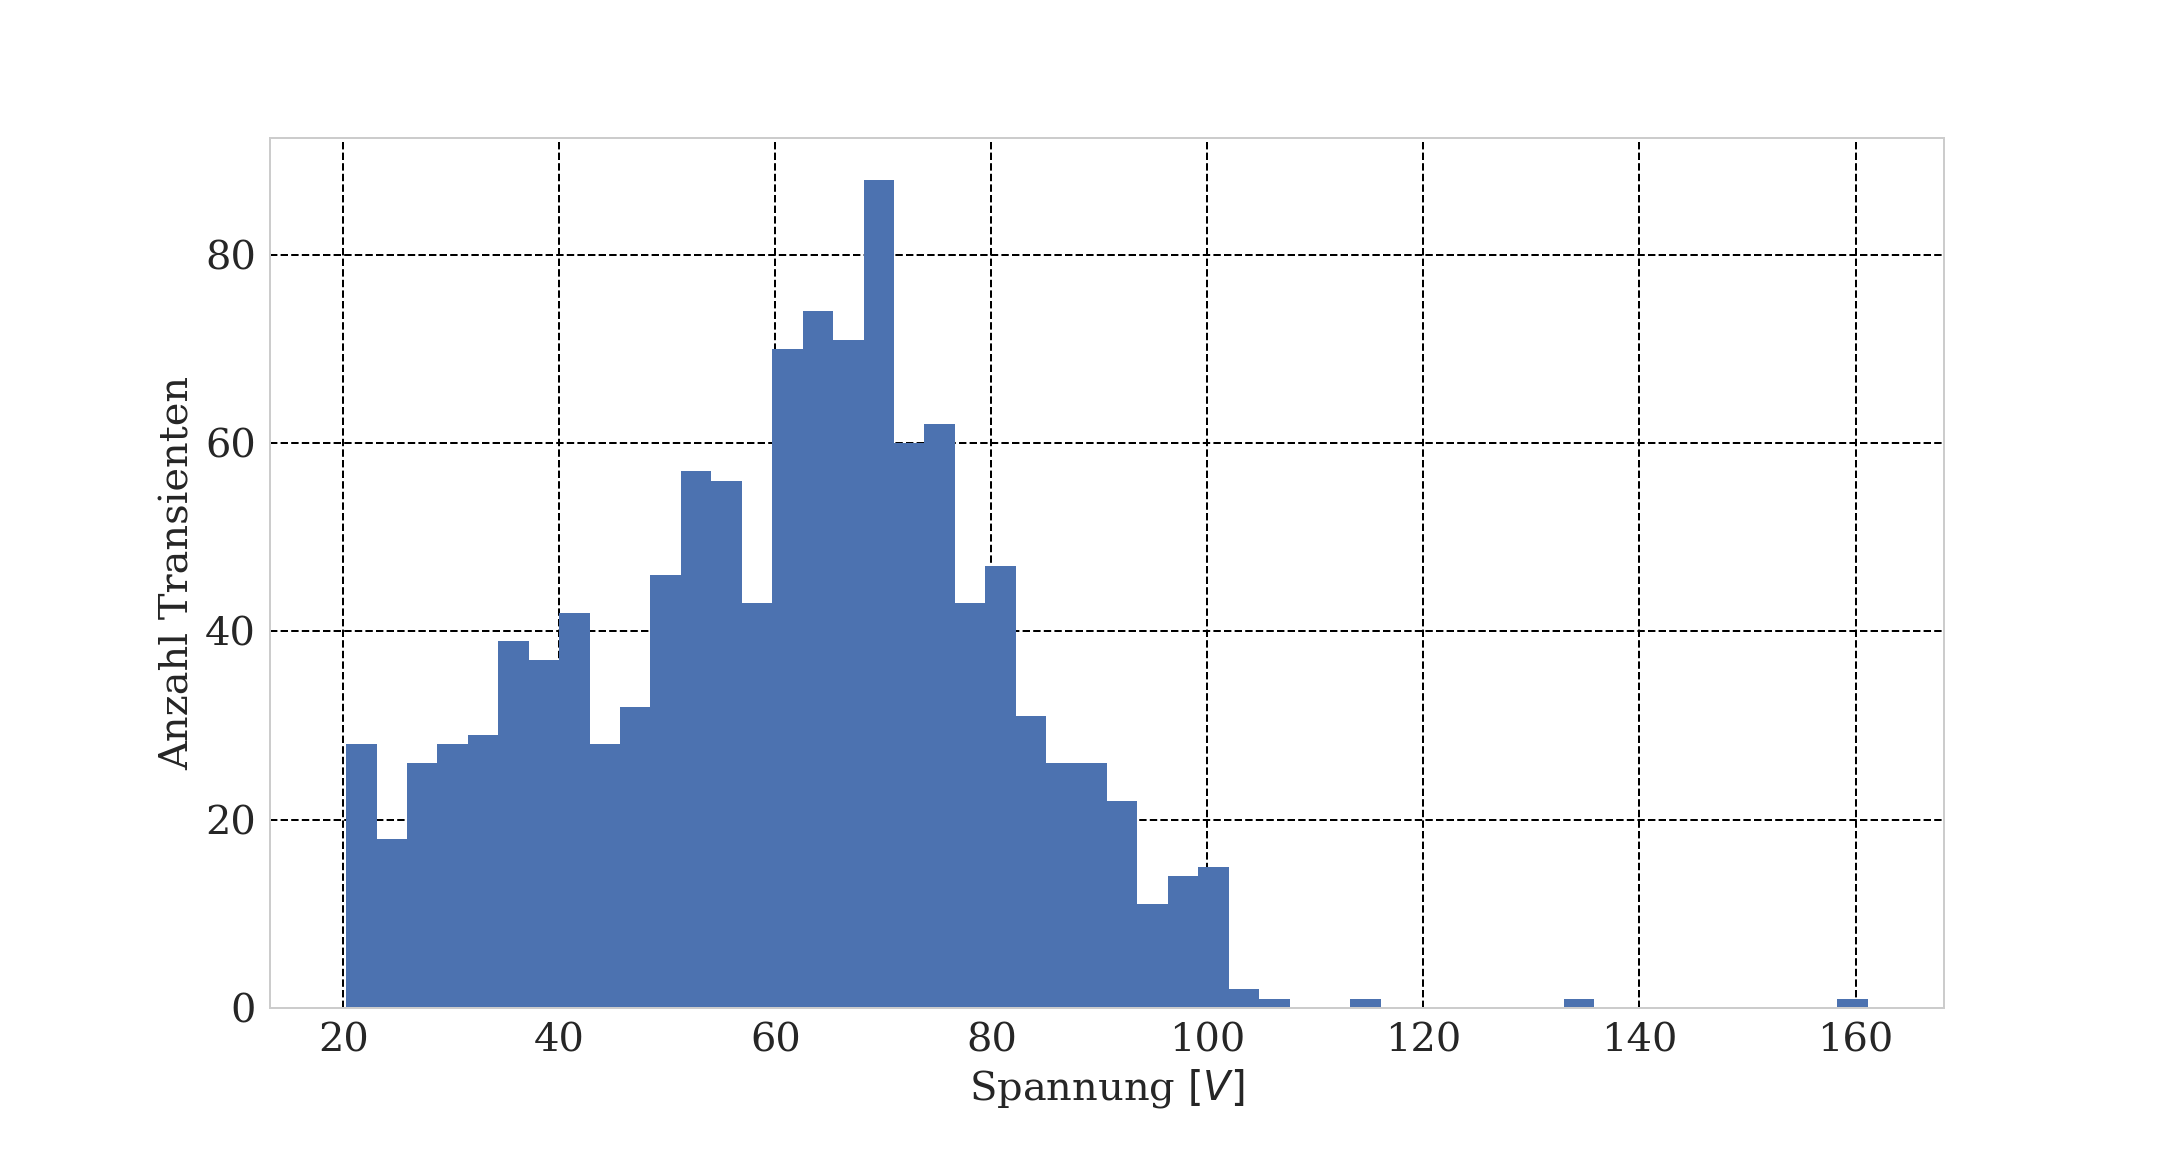

In [79]:
plt.figure(5)
# Initialize the matplotlib figure
xlabel(r'Spannung $[V]$')
plot_dia['max'].plot.hist(bins=50, figsize=(15,8), grid=True)
ylabel(r"Anzahl Transienten")
savefig('verteilung_spannungspeaks.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


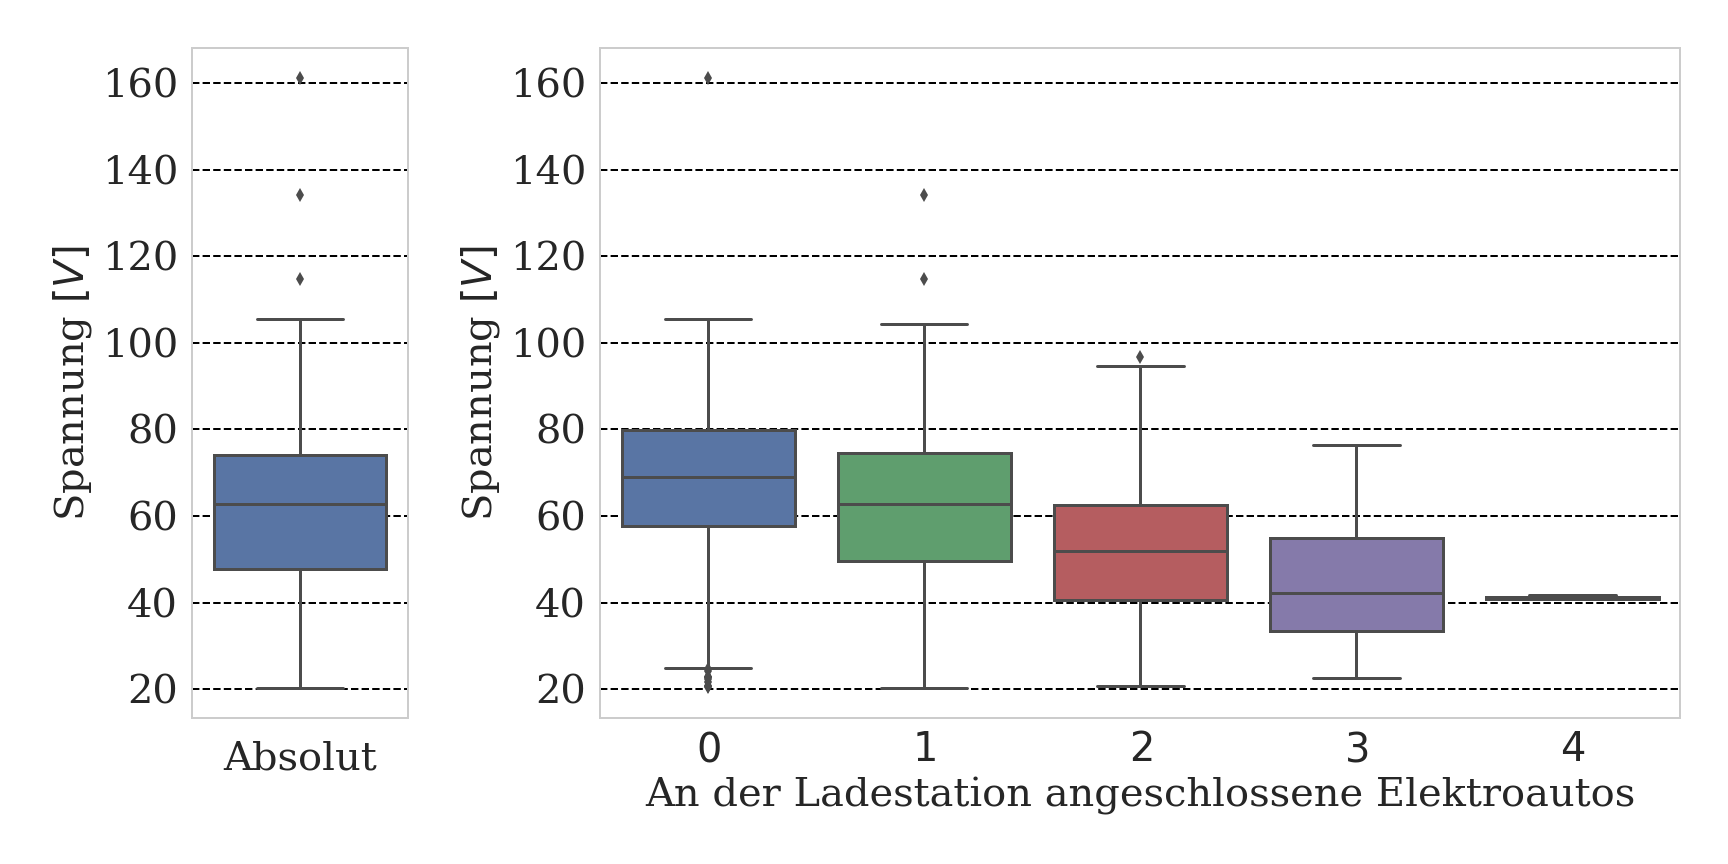

/Users/markus/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


In [82]:
import matplotlib.gridspec as gridspec

tips = sns.load_dataset("tips")

gridkw = dict(width_ratios=[1, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(12,6))

ax_1 = sns.boxplot(y=plot_dia["max"], ax=ax1) #array, top subplot
ax_1.set_ylabel(ylabel=r"Spannung $[V]$")
ax_1.set_xlabel(xlabel=r"Absolut")

ax_2 = sns.boxplot(data=plot_dia, x="cars_on_this_phase", y="max") #bottom subplot
ax_2.set_xticklabels([r'$0$', r'$1$', r'$2$', r'$3$', r'$4$'])
ax_2.set_xlabel(xlabel=r"An der Ladestation angeschlossene Elektroautos")
ax_2.set_ylabel(ylabel=r"Spannung $[V]$")

plt.tight_layout()
plt.show()
savefig('max_peak_anzahl_auto.pdf', format='pdf', dpi=1200)

In [8]:
# kommt in doku
# transienten on other phase raus

In [9]:
plugin_on_this_phase['cars_on_this_phase'].head()

2     0.0
4     1.0
6     1.0
18    1.0
20    0.0
Name: cars_on_this_phase, dtype: float64

<IPython.core.display.Javascript object>


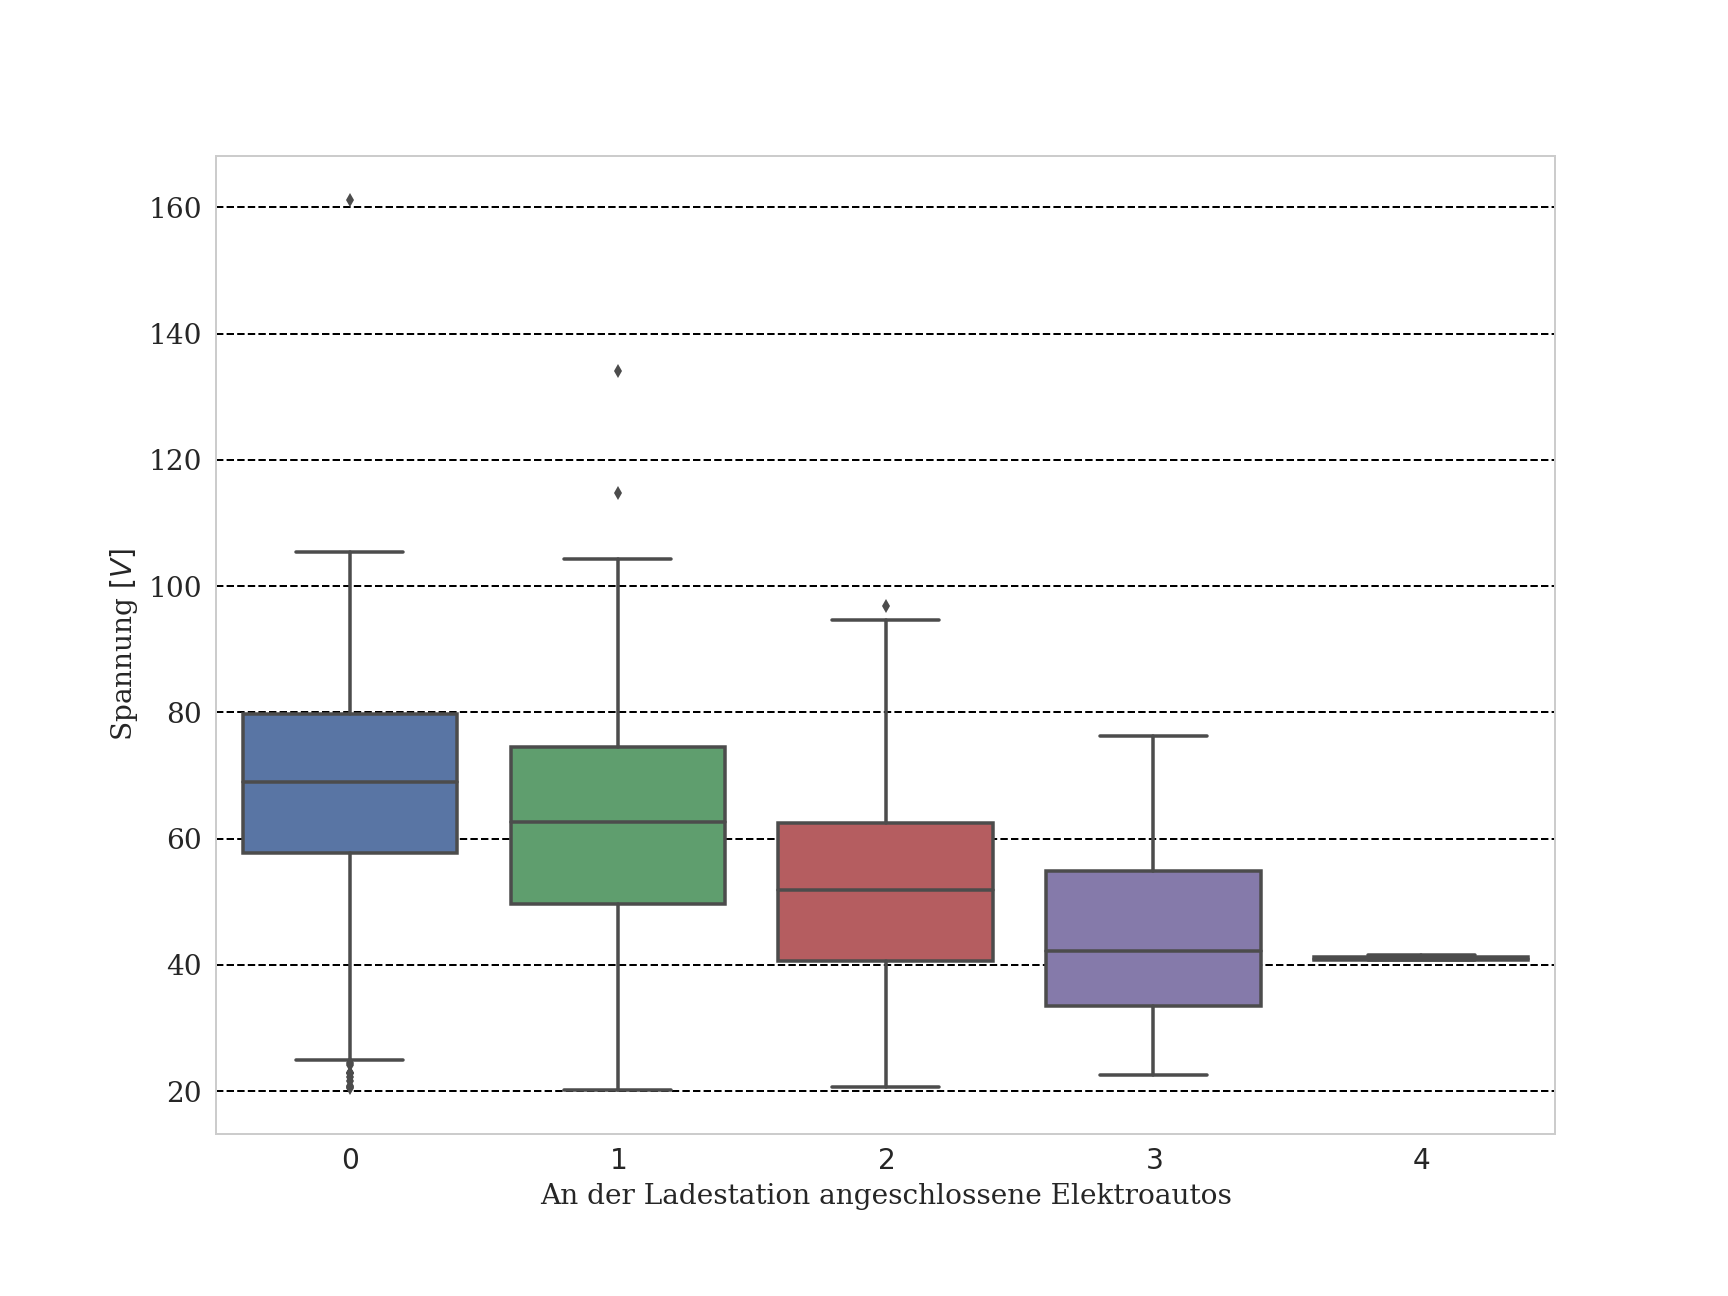

/Users/markus/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


In [31]:
plugin_on_this_phase = data[data['plugin_on_this_phase']]

# prepare data
plot = plugin_on_this_phase.copy()
plot = plot[plot['max'] < 200]

#plt.figure()
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

ax = sns.boxplot(x="cars_on_this_phase", y="max", data=plot)
ax.set_xticklabels([r'$0$', r'$1$', r'$2$', r'$3$', r'$4$'])
#ax.grid(True)
ax.set_xlabel(xlabel=r"An der Ladestation angeschlossene Elektroautos")
ax.set_ylabel(ylabel=r"Spannung $[V]$")
savefig('max_peak_anzahl_auto.pdf', format='pdf', dpi=1200)

## Einfluss auf die Transienten von Außerhalb

In [7]:
# kommt in doku

<IPython.core.display.Javascript object>


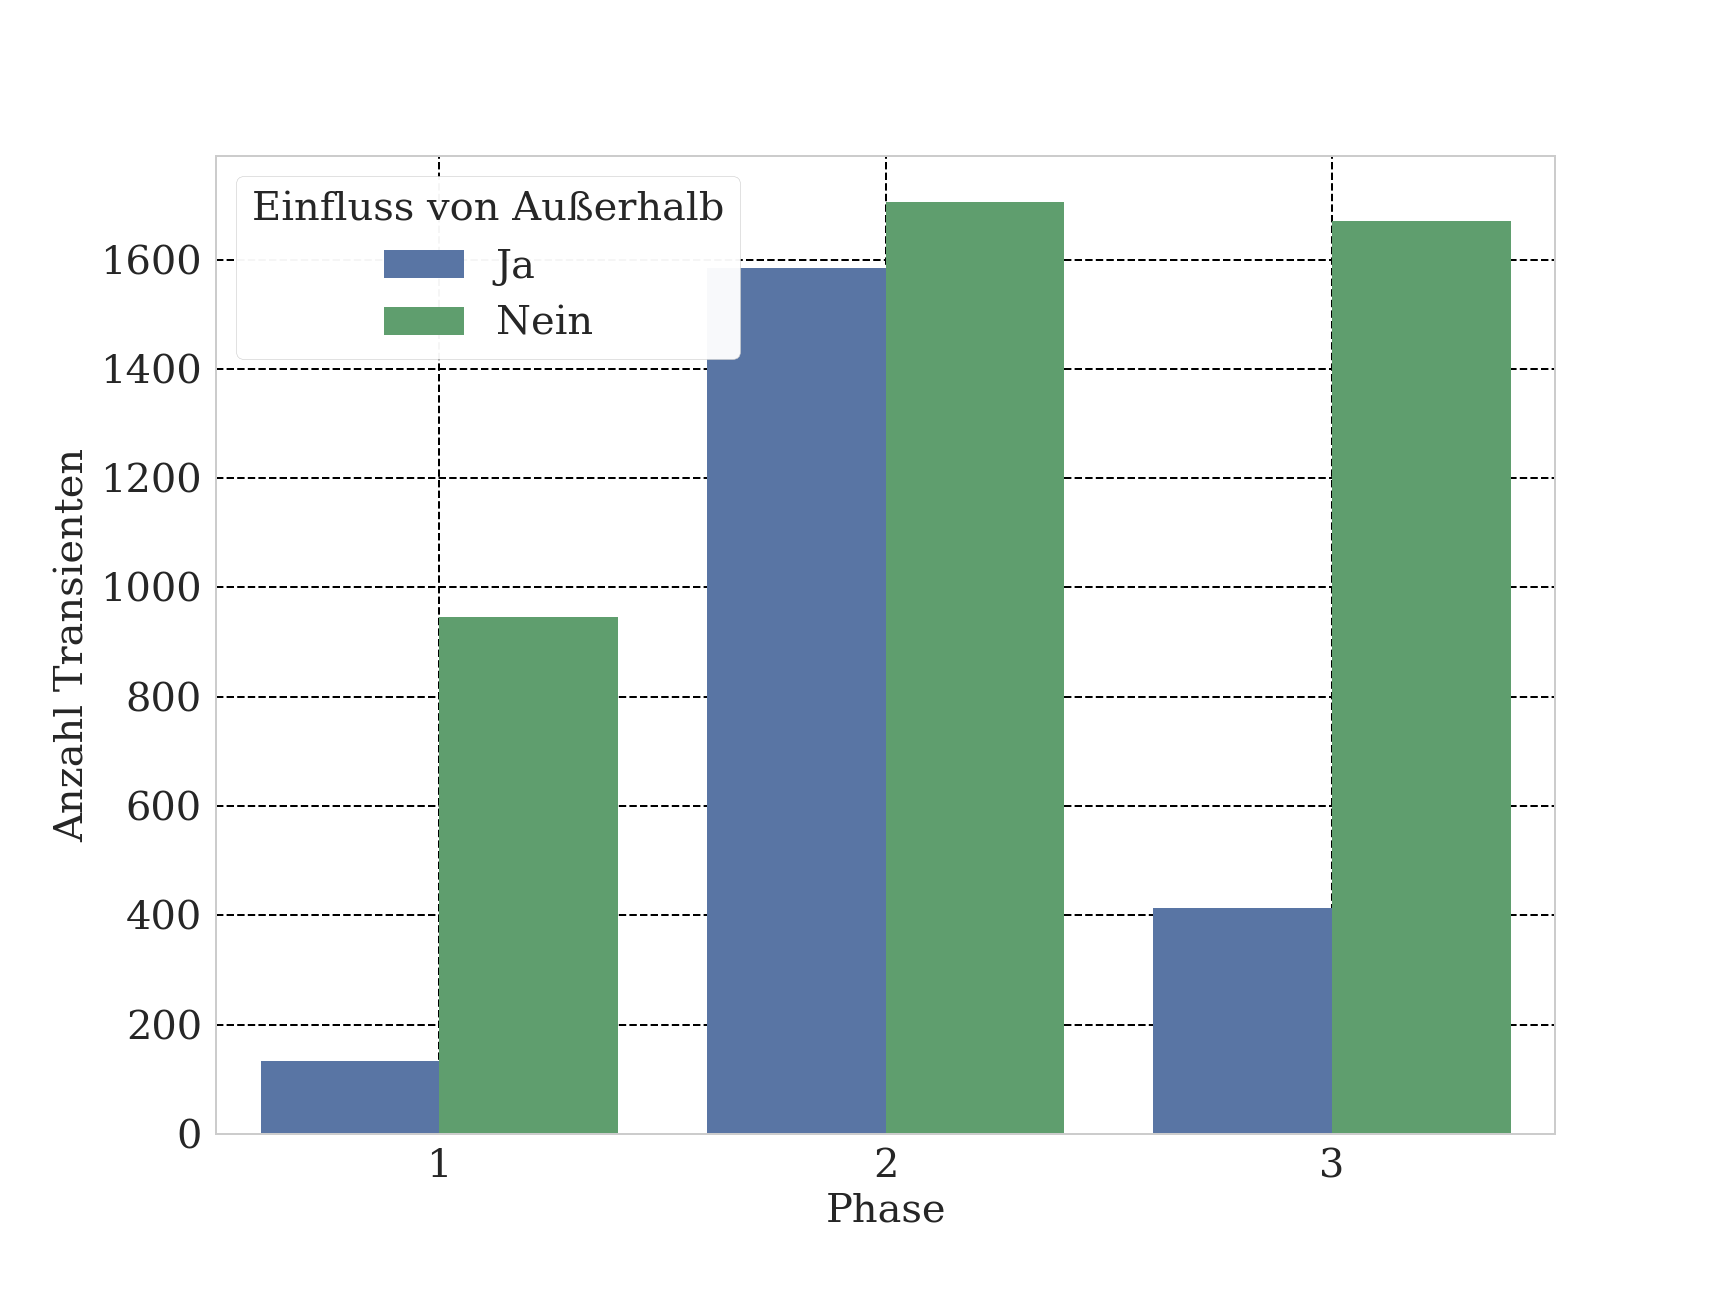

/Users/markus/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


In [11]:
data['einfluss_von_ausserhalb'] = data['event_from_outside'].apply(lambda x: r'Ja' if(x) else r'Nein')

f, ax = plt.subplots(figsize=(12, 9))
sns.set_style({'legend.frameon':True, 'legend.framealpha' : 10})
ax = sns.countplot(x="phase_num", hue="einfluss_von_ausserhalb", data=data)
ax.grid(True)
ax.set_xlabel(xlabel=r"Phase")
ax.set_ylabel(ylabel=r"Anzahl Transienten")
l = ax.legend()
l.set_title(r"Einfluss von Außerhalb")
savefig('einfluss_von_ausserhalb.pdf', format='pdf', dpi=1200)

--> Events from outside rausschmeißen

In [ ]:
data = data[~data['event_from_outside']]

### Beginnt zum Auftrittszeitpunkt der Transiente ein Ladevorgang?

In [ ]:
def plugin_cluster(row):
    if(row['plugin_on_this_phase']):
        return r'0'
    elif(row['plugin_on_other_phase']):
        return r'1'
    return r'2'

In [ ]:
data['plug_in_deu'] = data.apply(plugin_cluster, axis=1)

f, ax = plt.subplots(figsize=(15, 9))

ax = sns.countplot(x="phase_num", hue="plug_in_deu", data=data)
ax.grid(True)
ax.set_xlabel(xlabel=r"Phase")
ax.set_ylabel(ylabel=r"Anzahl der Transienten Total")
plt.legend(loc='upper left')
l = ax.legend()
l.set_title(r"Einschaltvorgang")
# Einschaltvorgang auf dieser Phase

Erkenntnis:

Wie zu erkennen tretten während des Ladevorgangs viele Transienten auf (Kategorie 2). Das kann von den Transienten kommen die von Außen eingeführt werden, da die einen großen Teil ausmachen, wie in der Grapik davor zusehen ist. Daher sollte in einer weiterführenden Arbeit versucht werden diese rauszufiltern.

## Ursache für die Transienten

In [ ]:
def clustering_transients(row):
    if(row['plugin_on_this_phase']):
        return r'Einschaltvorgang'
    
    elif(row['plugin_on_other_phase']):
        return r'Einschaltvorgang andere Phase'
    
    elif(row['Leistungsdip_on_this_phase']):
        return r'Leistungseinbruch'
    
    elif(row['Leistungsdip_on_other_phase']):
        return r'Leistungseinbruch andere Phase'
    
    elif(row['Sonstige_Leistungsaenderung_this_phase']):
        return r'Sonstige Leistungs\"anderung'
    
    elif(row['Sonstige_Leistungsaenderung_other_phase']):
        return r'Sonstige Leistungs\"anderung andere Phase'
        
    elif(row['Gezappel_on_this_phase']):
        return 'Leistungsschwankung'
    
    return 'Keine Zuordnung'

In [ ]:
data['Cluster'] = data.apply(clustering_transients, axis=1)

In [ ]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

ax = sns.countplot(x="phase_num", hue="Cluster", data=data)
ax.grid(True)
ax.set_xlabel(xlabel=r"Phase")
ax.set_ylabel(ylabel=r"Anzahl der Transienten Total")
plt.legend(loc='upper left')
#savefig('gradient_anzahl_auto.pdf', format='pdf', dpi=1200)

Erkenntnis:

Hier ist eine Kategorie zuerkennen, die keinem Cluster zugeordnet werden kann. Im Leistungsbereich findet hier nicht statt, deshalb kann davon ausgegangen werden, das diese Transiente von außerhalb kommt und mit dem eigentlichen Ladevorgang nichts zu tun hat.

In [ ]:
# dazukann ich die anderen darteien verwenden. Event_dfs

In [ ]:
print(data.columns)
data['stunden_minuten phase_num one_phase two_phases three_phases cars_phase_1 cars_phase_2 cars_phase_3 plugin_on_this_phase plugin_on_other_phase'.split()].head(20)

In [ ]:
data.columns

In [ ]:
data['stunden_minuten phase_num one_phase two_phases three_phases cars_phase_1 cars_phase_2 cars_phase_3 plugin_on_this_phase plugin_on_other_phase'.split()]

In [ ]:
data.info()

# Untersuchung der zeitlichen Häufung von Transienten (15 min bins)

In [10]:
df = data[['plugin_on_this_phase','Leistungsdip_on_this_phase',
           'Sonstige_Leistungsaenderung_this_phase','event_from_outside', 'Gezappel_on_this_phase']]
df.columns = [r'Einschaltvorgang', r'Leistungseinbruch', r'Sonstige Leistungsänderung', r'Einfluss von Außerhalb',
              r'Leistungsschwankung']
melted = pd.melt(df)
melted = pd.crosstab(index=[melted['value']], columns=[melted['variable']])

In [11]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 22
mpl.rcParams['lines.color'] = 'k'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'

In [54]:
list(melted.loc[True].values)

[2132, 1176, 259, 6, 895]

In [57]:
sorted(list(melted.loc[True].values), reverse=True)

[2132, 1176, 895, 259, 6]

In [64]:
labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels, total)]

In [65]:
labels

['Einfluss von Außerhalb, 47.7 %',
 'Einschaltvorgang, 26.3 %',
 'Sonstige LeistungsänderungLeistungseinbruch, 20.0 %',
 'Leistungsschwankung, 5.7 %']

<IPython.core.display.Javascript object>


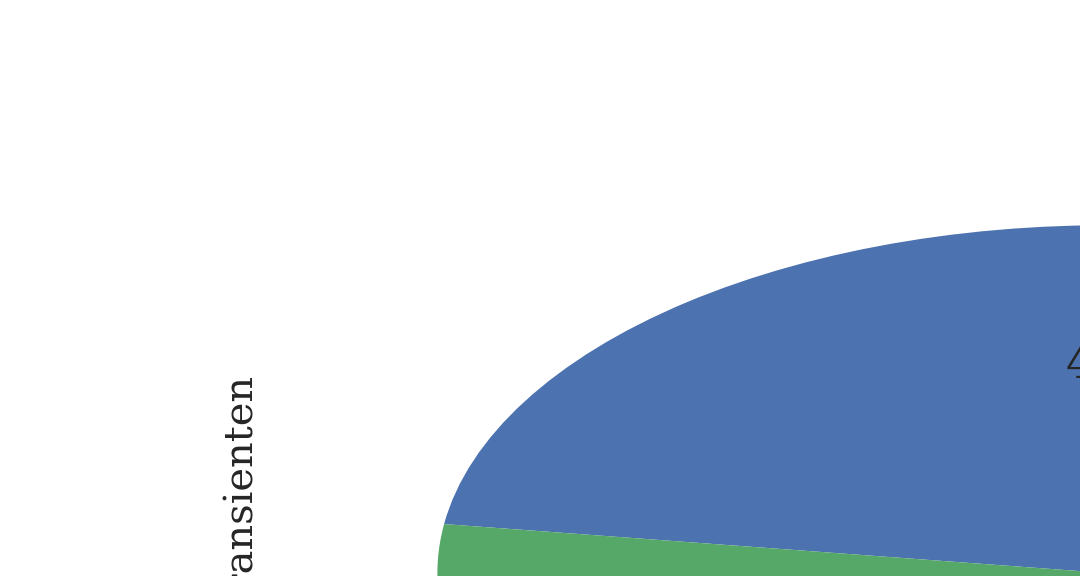

/Users/markus/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:521: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


In [75]:
fig = plt.figure(2, figsize=(10,10))
total = [47.7, 26.3, 20.0, 5.8, 0.1]
labels = [r'Einfluss von Außerhalb',
          r'Einschaltvorgang', 
          r'Sonstige Leistungsänderung',
          r'Leistungseinbruch',
          r'Leistungsschwankung']
plt.pie(total, autopct=r'%1.1f%%')
plt.legend(pie[0],frameon = True, framealpha=10, labels=labels, bbox_to_anchor=(0,1), loc="upper left", 
                          bbox_transform=plt.gcf().transFigure)
savefig('verteilung_vorgänge.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


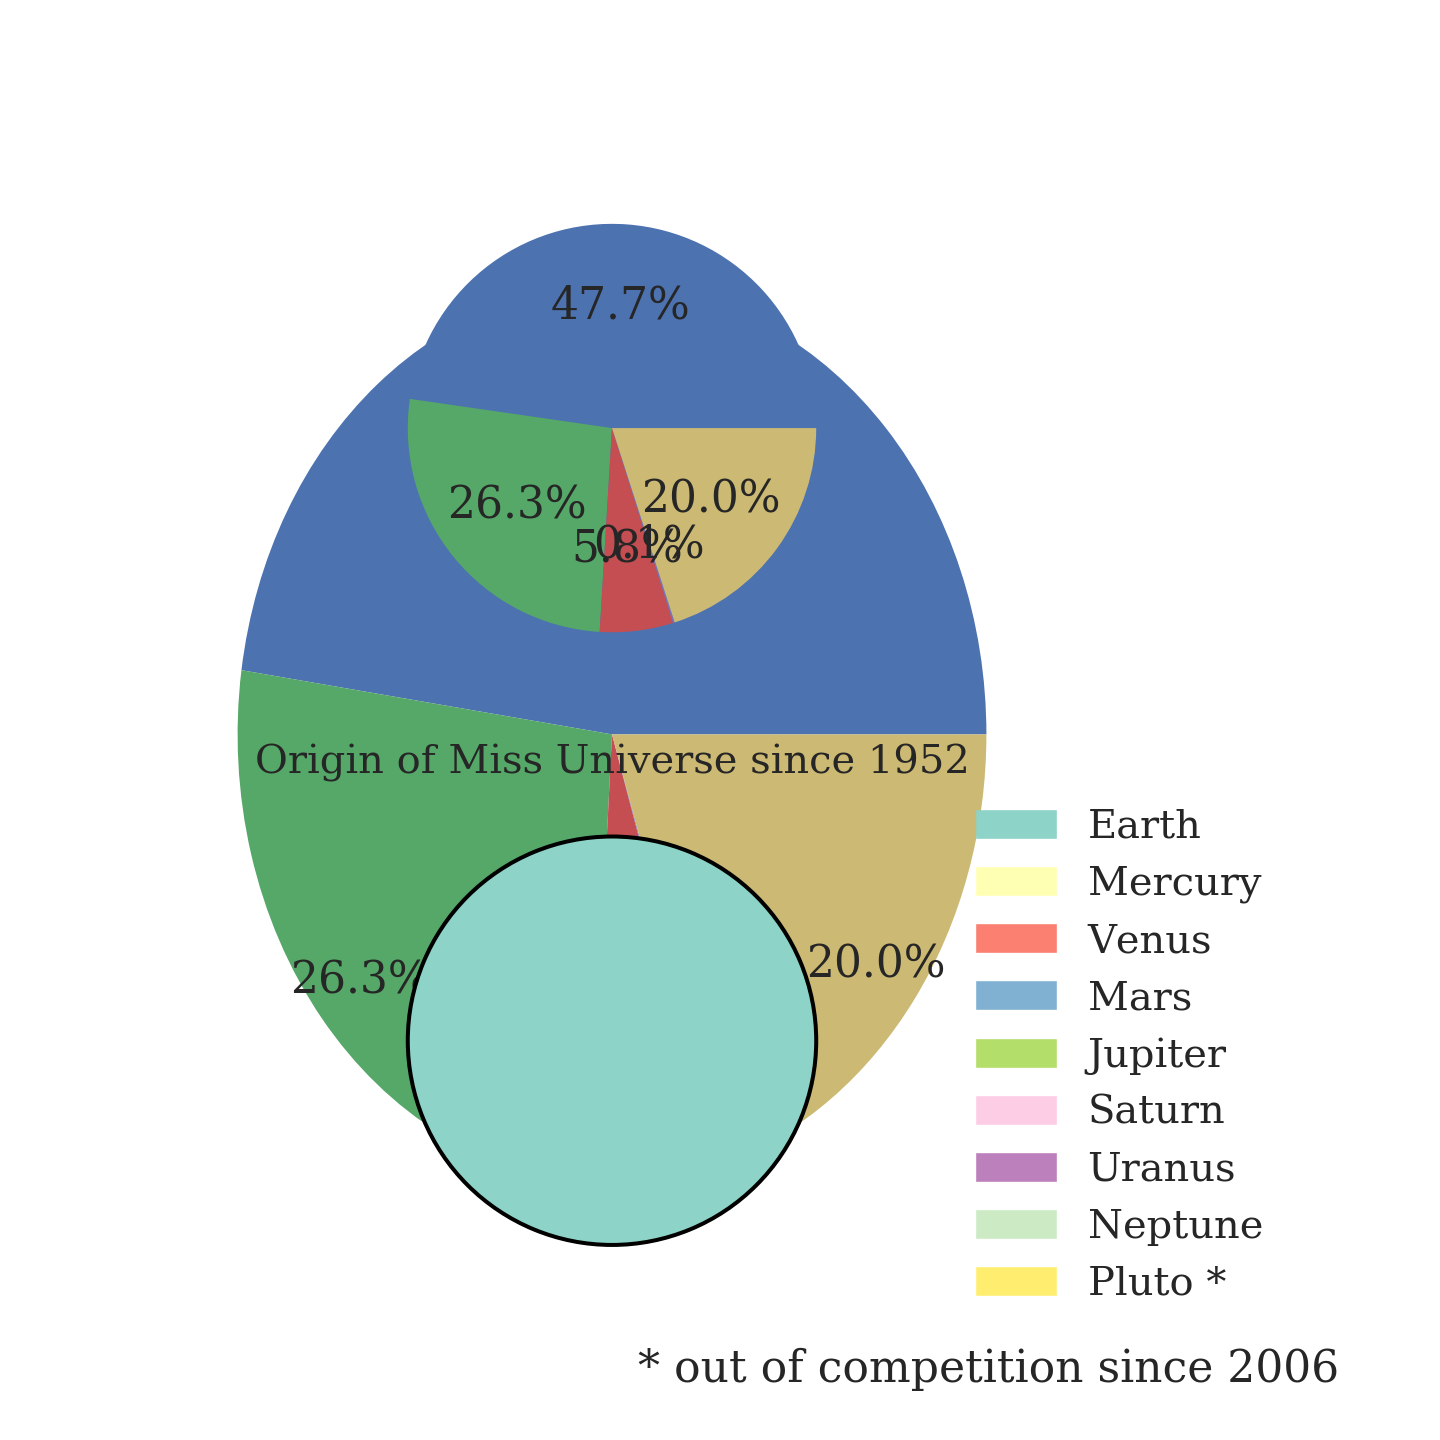

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [r'Einfluss von Außerhalb',
          r'Einschaltvorgang', 
          r'Leistungseinbruch',
          r'Leistungsschwankung',
          r'Sonstige Leistungsänderung']
sizes = list(melted.loc[True].values)

fig1, ax1 = plt.subplots(figsize=(10,10))
patches, texts, pct = ax1.pie(sizes, labels=None, autopct=r'%1.1f%%', pctdistance=0.87)

plt.legend(patches, labels, bbox_to_anchor=(1,0.85), loc="center right", fontsize=20, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.85)
plt.show()

savefig('verteilung_vorgänge.pdf', format='pdf', dpi=1200)

In [ ]:
# Verteilung der verschiedenen Transientenereignissen
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Verteilung alle Transienten Events 6454')
melted.loc[True].plot.pie(autopct='%1.1f%%')
savefig('verteilung_art_transient_events.pdf')

In [ ]:
data['cluster'] = data.apply(clustering_transients, axis=1)

In [ ]:
data.drop(['Leistungsdip_on_this_phase', 'Leistungsdip_on_other_phase',
           'Gezappel_on_this_phase', 'Sonstige_Leistungsaenderung_this_phase',
           'Sonstige_Leistungsaenderung_other_phase', 'event_from_outside'], axis=1, inplace=True)

In [ ]:
data['max_peak'] = data['three_first_peaks'].apply(lambda x: np.array(list(map(float, x))).max())

In [ ]:
plot_data = data[data['max_peak'] < 300]

# Verteilung Max peaks

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax = ax, x='cluster', y='max_peak', data=plot_data);

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(ax= ax, x='cluster', y='max_peak', data=plot_data)

# Verteilung Gradient

In [ ]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax = ax, x='cluster', y='transient_rise_gradient', data=plot_data);

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(ax= ax, x='cluster', y='transient_rise_gradient', data=plot_data)

# Verteilung Gradient abs

In [ ]:
plot_data_abs = plot_data.copy()
plot_data_abs['transient_rise_gradient'] = plot_data['transient_rise_gradient'].abs()

In [ ]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax = ax, x='cluster', y='transient_rise_gradient', data=plot_data_abs);

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(ax= ax, x='cluster', y='transient_rise_gradient', data=plot_data_abs)

In [ ]:
data_plugin_on_phase.head()

In [ ]:
data_plugin_on_phase.iloc[2]

In [ ]:
t1 = np.arange(0.0, len(data_plugin_on_phase.iloc[2]['filtered_signal']), 1)
plt.figure(figsize=(10,10))
plt.plot(t1, data_plugin_on_phase.iloc[2]['filtered_signal'])

In [ ]:
data_plugin_on_phase = data[data['plugin_on_this_phase']]

In [ ]:
data_plugin_on_phase.head()

In [ ]:
filtered_signal = data_plugin_on_phase["filtered_signal"].apply(pd.Series).fillna(0)
filtered_signal = filtered_signal.iloc[:50,:].transpose()
filtered_signal.columns = [i for i in range(filtered_signal.shape[1])]

In [ ]:
master_df = pd.DataFrame(filtered_signal[0])
master_df['id'] = 0

for i in range(1,len(filtered_signal.columns)): #len(df_raw_signal_voltage_t.columns)
    signal_df = pd.DataFrame(filtered_signal[i])
    signal_df['id'] = i
    master_df = pd.DataFrame(np.vstack([master_df, signal_df]))

In [ ]:
sns.set(style="ticks")

# Initialize a grid of plots with an Axes for each transient
grid = sns.FacetGrid(master_df, col=1, hue=1, col_wrap=2, size=10)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, 0, ms=4)

In [ ]:
for title, group in plugin_on_this_phase.groupby('cars_on_this_phase'):
    print(title)
    print("\n")
    #display(group.head(5))
    plot_transients(group.head(5),len(group.head(5))-1,'filtered_signal',2)
    print("\n")

In [ ]:
cars_on_this_phase

In [ ]:
data.info()

In [ ]:
data['hour'] = data['begin_timestamp'].dt.hour
data['hour'] = data['hour'].astype(str)
data['minute'] = data['begin_timestamp'].dt.minute
data['minute'] = data['minute'].astype(str)
data['sekunde'] = data['begin_timestamp'].dt.second
data['sekunde'] = data['sekunde'].astype(str)

In [ ]:
data['time'] = data['hour'] + data['minute'] + data['sekunde']

In [ ]:
data.head()

In [ ]:
data['time'] = data['time'].str.replace('.', '')

In [ ]:
data.head()

In [ ]:
data.info()